<a href="https://colab.research.google.com/github/deepskies/noise2self/blob/master/notebooks/Data_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise2Self for Astro

In astronomy datasets, one often acquires many images of the same part of the sky, with different shot, read-out, cosmic ray, and detector noise. Instead of averaging those images, we may train a network to predict one from the other. The resulting output will be a denoised image.

In the simplest case, we have two or more images, and we may use one two predict the other (the Noise2Noise regime). Given more images, we may design a more complicated architecture to take advantage of their multiplicity (instead of merely averaging them to make pairs).

In [1]:
#!rm -r noise2self
#%cd ..
#!rm -r noise2self
!git clone https://github.com/deepskies/noise2self.git

Cloning into 'noise2self'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 133 (delta 61), reused 92 (delta 29), pack-reused 0
Receiving objects: 100% (133/133), 12.47 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
%cd noise2self

/content/noise2self


In [0]:
from util import show, plot_images, plot_tensors, plot_grid

# Simulated Galaxy Dataset 1

In [5]:
!pip install astropy

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [0]:
fnames = glob("../gdrive/My Drive/Noise2Astro/cutouts_v1/*.gz")
fnames = sorted(fnames)

In [15]:
from astropy.io import fits
print("Number of files: ", len(fnames))

Number of files:  998


Load data

In [16]:
galaxies = {}
# Iterates over filenames to parse information
i = 0
for file in fnames:
    _, _, gal_id = os.path.splitext(os.path.basename(file))[0].split('_')
    gal_id = "gal_" + gal_id.replace('.fits', '')
    hdus = fits.open(file)
    imgs = hdus[0].data
    galaxies[gal_id] = imgs
    i += 1
    if i % 50 == 0:
      print(np.round(100*(i + .0)/len(fnames)), "% loaded.")

5.0 % loaded.
10.0 % loaded.
15.0 % loaded.
20.0 % loaded.
25.0 % loaded.
30.0 % loaded.
35.0 % loaded.
40.0 % loaded.
45.0 % loaded.
50.0 % loaded.
55.0 % loaded.
60.0 % loaded.
65.0 % loaded.
70.0 % loaded.
75.0 % loaded.
80.0 % loaded.
85.0 % loaded.
90.0 % loaded.
95.0 % loaded.


In [0]:
# Join image 0 and image 1 from each galaxy
data = np.stack([(galaxies[gal_id][0], galaxies[gal_id][1]) for gal_id in galaxies])

In [0]:
def mean(x):
  return x.mean(-1).mean(-1)
def mse(x, y):
  return mean((x - y)**2)

(array([  1.,   0., 550., 340.,  59.,  13.,  10.,   9.,   4.,   3.,   1.,
          3.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   1.]),
 array([-42.57349 , -26.540731, -10.507972,   5.524788,  21.557547,
         37.590305,  53.623066,  69.65582 ,  85.68858 , 101.721344,
        117.754105, 133.78687 , 149.81963 , 165.85239 , 181.88515 ,
        197.9179  , 213.95065 , 229.98341 , 246.01617 , 262.04895 ,
        278.0817  ], dtype=float32),
 <a list of 20 Patch objects>)

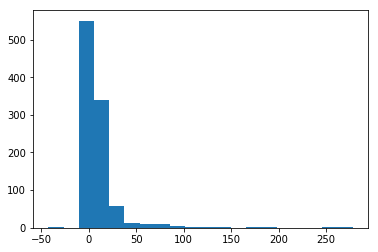

In [24]:
# Distribution of per-image intensity
plt.hist(mean(data[:,0]), bins = 20)
#plt.yscale('log')

Text(0, 0.5, 'noise draw 2')

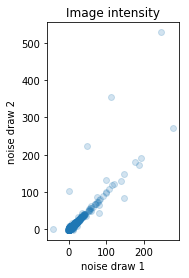

In [29]:
# Distribution of mean before-after
plt.scatter(mean(data[:,0]), mean(data[:,1]), alpha = 0.2)
plt.gca().set_aspect('equal')
plt.title('Image intensity')
plt.xlabel('noise draw 1')
plt.ylabel('noise draw 2')

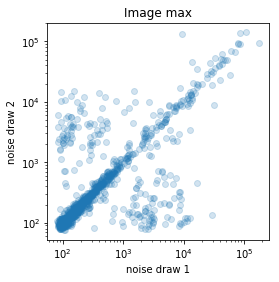

In [31]:
# Distribution of max before-after
plt.scatter((data[:,0].max(-1).max(-1)), data[:,1].max(-1).max(-1), alpha = 0.2)
plt.gca().set_aspect('equal')
plt.title('Image max')
plt.xlabel('noise draw 1')
plt.ylabel('noise draw 2')
plt.yscale('log')
plt.xscale('log')

Text(0.5, 1.0, 'MSE between two noisy images')

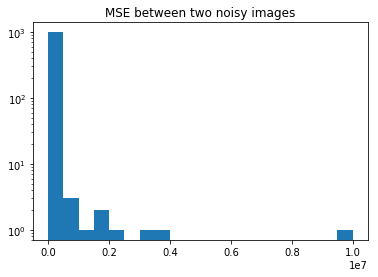

In [37]:
# Distribution of mse before-after
plt.hist(mse(data[:, 0], data[:, 1]), bins = 20)
plt.yscale('log')
plt.title('MSE between two noisy images')

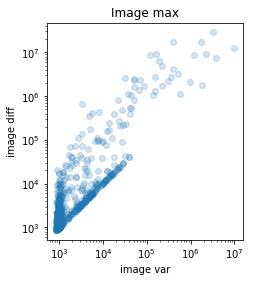

In [41]:
plt.scatter(mse(data[:, 0], data[:, 1]), mse(data[:,0], 0) + mse(data[:, 1], 0), alpha = 0.2)
plt.gca().set_aspect('equal')
plt.title('Image max')
plt.xlabel('image var')
plt.ylabel('image diff')
plt.yscale('log')
plt.xscale('log')

In [0]:
relative_error = mse(data[:, 0], data[:, 1])/(mse(data[:,0], 0) + mse(data[:, 1], 0))
top_relative_errors = np.argsort(relative_error)[::-1][:5]

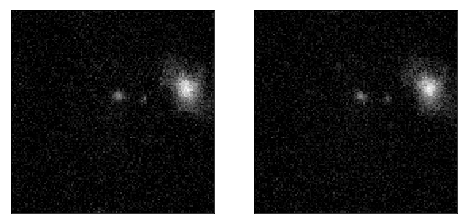

In [104]:
# A typical image pair
sample = data[100]
plot_images(sample, vmin = 0, vmax = sample.max())

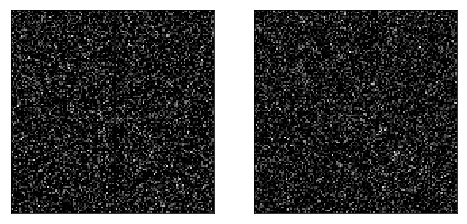

In [107]:
# A bad image pair
sample = data[top_relative_errors[3]]
plot_images(sample, vmin = 0, vmax = sample.max())

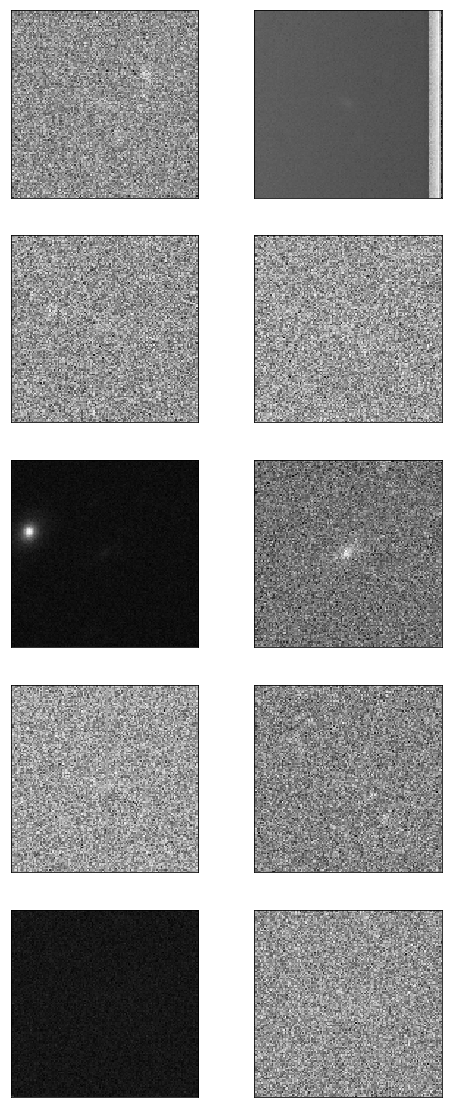

In [93]:
plot_grid(np.reshape(data[top_relative_errors], (len(top_relative_errors)*2, 128, 128)), 5, 2)

In [0]:
normed_data = data/255

In [0]:
normed_train_data = normed_data[:800,:,:128,:128]
normed_val_data = normed_data[800:900,:,:128,:128]
normed_test_data = normed_data[900:,:,:128,:128]

In [0]:
from models.singleconv import SingleConvolution
from models.dncnn import DnCNN
device = 'cuda'
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch

In [0]:
# Sets up basic cnn as in Training section above
model = SingleConvolution(width=5)
#model = DnCNN(1, num_of_layers=12)
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
batch_size = 16

train_loader = DataLoader(normed_train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(normed_val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(normed_test_data, batch_size=batch_size, shuffle=False)
all_loader = DataLoader(normed_data,
                        batch_size=batch_size,
                        shuffle=False)

In [67]:
# Main Training Loop
# Operates just as in Training section above
# Loss accounted for in a per average batch per epoch basis
n_epochs = 100
best_loss = 100000

train_losses = []
train_losses_med = []
val_losses = []
val_loss_med = []

best_model={}

for epoch in range(n_epochs):
  
    train_loss = 0

    for i, batch in enumerate(train_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        train_loss += loss.cpu().item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    train_losses.append(train_loss/len(train_loader))
    
    # Keeps track of loss over 10 epochs

    val_loss = 0
    for i, batch in enumerate(val_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)  
        val_loss += loss.cpu().item()
       
    val_losses.append(val_loss/len(val_loader))
    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()        
    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(train_loss/len(train_loader), 3),
             "\t", round(val_loss/len(val_loader), 3))
      
    optimizer.zero_grad()
    
torch.save(best_model, '../gdrive/My Drive/Noise2Astro/baseline_model')


Loss ( 0 ): 	 0.8 	 0.778
Loss ( 10 ): 	 0.484 	 0.643
Loss ( 20 ): 	 0.477 	 0.642
Loss ( 30 ): 	 0.474 	 0.642
Loss ( 40 ): 	 0.472 	 0.642
Loss ( 50 ): 	 0.471 	 0.641
Loss ( 60 ): 	 0.47 	 0.641
Loss ( 70 ): 	 0.469 	 0.641
Loss ( 80 ): 	 0.469 	 0.641
Loss ( 90 ): 	 0.468 	 0.641


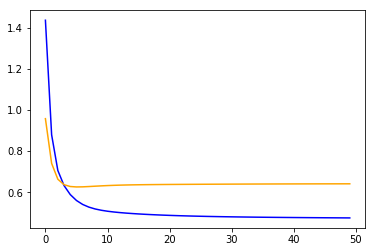

In [58]:
plt.plot(train_losses, color="blue")
plt.plot(val_losses, color="orange")

In [59]:
test_loss = 0
model.load_state_dict(best_model, strict=False)
for i, batch in enumerate(test_loader):
    batch = batch.to(torch.float)
    noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
    noisy_images_1 = noisy_images_1.to(device)
    noisy_images_2 = noisy_images_2.to(device)

    net_output = model(noisy_images_1)

    loss = loss_function(net_output, noisy_images_2)  
    test_loss += loss

print(f'Test Loss: {test_loss/len(test_loader)}')
i, test_batch = next(enumerate(test_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

Test Loss: 0.07549337297677994


In [0]:
def eval_model(x, model, batch_size=16):
  loader = DataLoader(x, batch_size=batch_size, shuffle=False)
  y = x.copy()
  for i, batch in enumerate(loader):
    batch = batch.to(torch.float).to(device)
    output = model(batch)
    y[i*batch_size:(i+1)*batch_size] = output.detach().cpu().numpy()
  return y

In [0]:
denoised = eval_model(normed_data[:,0:1], model)[:,0]*255
results = np.stack([data[:, 0], data[:, 1], denoised], axis = 1)

In [0]:
losses = mse(denoised, data[:, 1])

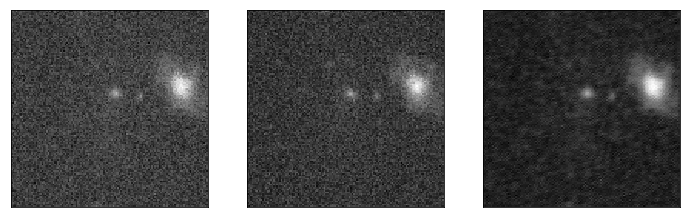

In [123]:
idx = 100
plot_images(results[idx])

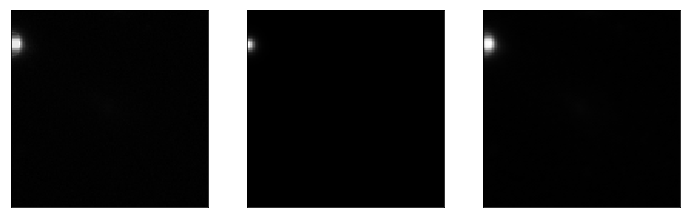

In [127]:
# without fixing the scale
idx = np.argmax(losses)
plot_images(results[idx])

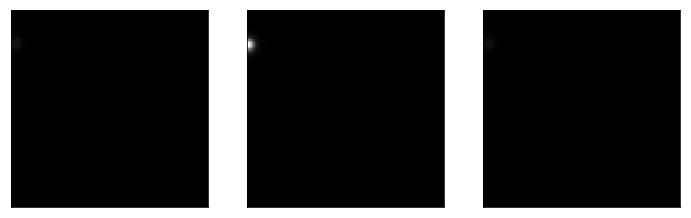

In [128]:
# fixing the scale
idx = np.argmax(losses)
plot_images(results[idx], vmin = 0, vmax = results[idx].max())

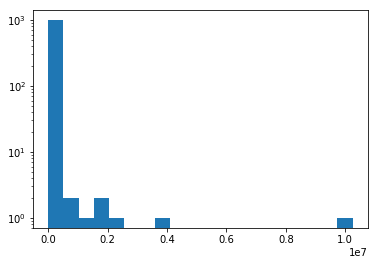

In [131]:
plt.hist(losses, bins = 20)
plt.yscale('log')

In [0]:
train_losses = losses[:800]
val_losses = losses[900:]
test_losses = losses[800:900]

In [151]:
# Medians
np.median(train_losses), np.median(val_losses), np.median(test_losses)

(600.1771, 589.1421, 606.0801)

In [153]:
# Means
np.mean(train_losses), np.mean(val_losses), np.mean(test_losses)

(30044.635, 4933.0596, 46593.945)

In [152]:
print("Train percentiles: \t", np.round(np.percentile(train_losses, np.arange(0, 100, 20))))
print("Val percentiles:\t", np.round(np.percentile(val_losses, np.arange(0, 100, 20))))
print("Test percentiles:\t", np.round(np.percentile(test_losses, np.arange(0, 100, 20))))

Train percentiles: 	 [ 505.  554.  582.  637. 2089.]
Val percentiles:	 [517. 553. 569. 606. 704.]
Test percentiles:	 [ 514.  549.  595.  624. 1839.]
